# DermAI_Comparative_Algorithms

              Palestine Technical University - Kadoorie
                
              Department of Computer Systems Engineering

              DermAI: Intelligent Skin Cancer Detection Using Convolutional Neural Network & Transfer Learning Architectures


**The main goal of this notebook is to select the optimal model for training the DermAI Skin Cancer Classification project.**

- Project: DermAI - Intelligent Skin Cancer Detection Using Convolutional Neural Network & Transfer Learning Architectures
- Dataset: 5,000 dermoscopic images (sample from main DermAI dataset)
- Distribution: 3,407 Benign / 1,593 Malignant (2:1 ratio - reflecting real prevalence)
- Platform: Google Colab with GPU acceleration
- Framework: TensorFlow 2.x / Keras
- Date: 1 Novembar 2025

#### **A detailed overview of this notebook**

**INTRODUCTION AND RESEARCH OBJECTIVES**
- *Background*:The DermAI project aims to develop an intelligent diagnostic system using deep learning for automated skin lesion classification.


- *Main Question* : Which machine learning or deep learning algorithm provides the most accurate, reliable, and efficient performance for binary classification of skin lesions (benign vs malignant) in the context of the DermAI system?


- *Contents:*
    1. Clean, Resize and perpare dataset for training
    2. Train and evaluate 10 different ML/DL algorithms on a standardized dataset
    3. Compare performance metrics: Accuracy, Precision, Recall, F1-Score
    4. Analyze confusion matrices and classification patterns
    5. Assess training efficiency and computational requirements
    6. Provide empirical justification for CNN selection in DermAI
                  
- *Models Under Investigation*
    1. Custom CNN (Convolutional Neural Network)
    2. ANN (Artificial Neural Network)
    3. KNN (K-Nearest Neighbors - Traditional ML)
    4. ResNet50 (Transfer Learning)
    5. VGG16 (Transfer Learning)
    6. EfficientNetB0 (Transfer Learning)
    7. InceptionV3 (Transfer Learning)
    8. Xception (Transfer Learning)
    9. DenseNet121 (Transfer Learning)

                 
- *Methodology Overview*
    - Dataset: 5,000 images sampled from DermAI main dataset
    - Split: 80% Training / 20% Validation
    - Preprocessing: Resize, Normalize, Augmentation
    - Evaluation: using standardized metrics on fixed 80/20 split
    - Visualization: Confusion matrices, performance curves, comparative charts

##

####  **Environoment**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU available: []


In [ ]:
# take break
%%javascript
function ClickConnect(){
    console.log("Preventing Colab timeout");
    document.querySelector("colab-toolbar-button#connect").click();
}
setInterval(ClickConnect, 60000)

<IPython.core.display.Javascript object>

     

---



#### Section 1: Environment Setup and Libraries Imports

In [ ]:
# Libraries
import os
import gc
import time
import random
import pickle
import warnings
from math import pi
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

warnings.filterwarnings('ignore')

# Deep Learning Frameworks
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import (
    ResNet50, VGG16, EfficientNetB0,
    InceptionV3, Xception, DenseNet121
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve
)
# Image Processing
import cv2

from google.colab import drive

#### Section 2: Dataset Preapre

In [ ]:
# Define Dataset Paths & Check
base_dir = '/content/drive/MyDrive/DermAI_Comparative_Algorithms/sample_Dataset'
folders = ["benign", "malignant"]

print("Base directory:", base_dir)
for folder in folders:
    path = os.path.join(base_dir, folder)
    print(f"{folder}: {len(os.listdir(path))} files")

Base directory: /content/drive/MyDrive/DermAI_Comparative_Algorithms/sample_Dataset
benign: 3402 files
malignant: 1593 files


Quick Check ( Clean, Resize to 224*224, plot distribution, etc...)

In [ ]:
import os
import shutil
from collections import defaultdict
from PIL import Image
from tqdm import tqdm
import hashlib

class ImageCleaner:
    def __init__(self, base_path):
        self.base_path = base_path
        self.folders_to_check = ['benign', 'malignant']
        self.problem_folder = os.path.join(base_path, 'duplicates_or_corrupted')
        os.makedirs(self.problem_folder, exist_ok=True)
        self.stats = {'total_checked': 0, 'corrupted': 0, 'duplicates': 0, 'low_quality': 0, 'healthy': 0}
        self.image_hashes = defaultdict(list)

    def calculate_hash(self, image_path):
        try:
            hasher = hashlib.md5()
            with open(image_path, 'rb') as f:
                buf = f.read()
                hasher.update(buf)
            return hasher.hexdigest()
        except:
            return None

    def is_image_corrupted(self, image_path):
        try:
            with Image.open(image_path) as img:
                img.verify()
            return False
        except:
            return True

    def check_image_quality(self, image_path, min_width=50, min_height=50):
        try:
            with Image.open(image_path) as img:
                width, height = img.size
                if width < min_width or height < min_height:
                    return False
                if os.path.getsize(image_path) < 1000:
                    return False
            return True
        except:
            return False

    def move_to_problem_folder(self, image_path):
        try:
            folder_name = os.path.basename(os.path.dirname(image_path))
            dest_subfolder = os.path.join(self.problem_folder, folder_name)
            os.makedirs(dest_subfolder, exist_ok=True)
            dest_path = os.path.join(dest_subfolder, os.path.basename(image_path))
            shutil.move(image_path, dest_path)
        except Exception as e:
            print(f"Error moving {os.path.basename(image_path)}: {e}")

    def clean_folder(self, folder_name):
        folder_path = os.path.join(self.base_path, folder_name)
        image_exts = ['.jpg', '.jpeg', '.png', '.bmp']

        all_files = os.listdir(folder_path)
        images = [os.path.join(folder_path, f) for f in all_files
                  if os.path.splitext(f)[1].lower() in image_exts]

        print(f"Cleaning {folder_name} ({len(images)} images)...")

        for img_path in tqdm(images, desc=f"Checking {folder_name}"):
            self.stats['total_checked'] += 1

            if self.is_image_corrupted(img_path):
                self.move_to_problem_folder(img_path)
                self.stats['corrupted'] += 1
                continue

            if not self.check_image_quality(img_path):
                self.move_to_problem_folder(img_path)
                self.stats['low_quality'] += 1
                continue

            img_hash = self.calculate_hash(img_path)
            if img_hash and img_hash in self.image_hashes:
                self.move_to_problem_folder(img_path)
                self.stats['duplicates'] += 1
            else:
                if img_hash:
                    self.image_hashes[img_hash].append(img_path)
                self.stats['healthy'] += 1

    def clean_all(self):
        for folder in self.folders_to_check:
            self.clean_folder(folder)
        print("\n" + "="*60)
        print("Cleaning Summary:")
        print("="*60)
        for k, v in self.stats.items():
            print(f"{k:20s}: {v:,}")
        print("="*60)

# Run the cleaning process
cleaner = ImageCleaner(base_dir)
cleaner.clean_all()

Cleaning benign (3402 images)...


Checking benign: 100%|██████████| 3402/3402 [01:11<00:00, 47.67it/s] 


Cleaning malignant (1593 images)...


Checking malignant: 100%|██████████| 1593/1593 [00:30<00:00, 52.46it/s] 


Cleaning Summary:
total_checked       : 4,995
corrupted           : 0
duplicates          : 0
low_quality         : 0
healthy             : 4,995


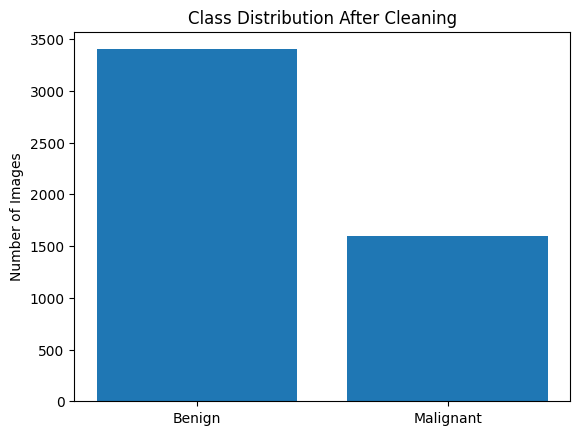

In [ ]:
# Visualize class distribution
count_benign = len(os.listdir(os.path.join(base_dir, "benign")))
count_malignant = len(os.listdir(os.path.join(base_dir, "malignant")))
plt.bar(["Benign", "Malignant"], [count_benign, count_malignant])
plt.title("Class Distribution After Cleaning")
plt.ylabel("Number of Images")
plt.show()

In [ ]:
# Resize all images to (224x224)
IMG_SIZE = (224, 224)
for cat in folders:
    src_dir = os.path.join(base_dir, cat)
    files = os.listdir(src_dir)
    for fname in tqdm(files, desc=f"Resizing {cat}"):
        path = os.path.join(src_dir, fname)
        try:
            img = cv2.imread(path)
            if img is None: continue
            resized = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)
            cv2.imwrite(path, resized)
        except:
            continue

Resizing malignant: 100%|██████████| 1593/1593 [00:20<00:00, 78.43it/s]


**Build DataFrame & Quick Integrity Check**

In [ ]:
# Count the number of image files in each class folder (benign and malignant)
# This function walks through all subdirectories and counts only valid image files.
import os, sys, traceback
base_path = "/content/drive/MyDrive/DermAI_Comparative_Algorithms/sample_Dataset"

def count_images_in_folder(folder):
    exts = ('.jpg','.jpeg','.png','.bmp')
    cnt = 0
    for root, dirs, files in os.walk(folder):
        for f in files:
            if f.lower().endswith(exts):
                cnt += 1
    return cnt

for cls in ['benign','malignant']:
    p = os.path.join(base_path, cls)
    if not os.path.exists(p):
        print(f" WARNING: folder not found: {p}")
    else:
        print(f"{cls}: {count_images_in_folder(p):,} images")

benign: 3,402 images
malignant: 1,593 images


In [ ]:
import os
import pandas as pd
from PIL import Image
import random
# build dataframe (paths + labels)
base_path = '/content/drive/MyDrive/DermAI_Comparative_Algorithms/sample_Dataset'
rows=[]
exts = ('.jpg','.jpeg','.png','.bmp')
for cls in ['benign','malignant']:
    folder = os.path.join(base_path, cls)
    if not os.path.exists(folder):
        continue
    for root, dirs, files in os.walk(folder):
        for fname in files:
            if fname.lower().endswith(exts):
                rows.append({'path': os.path.join(root, fname), 'label': cls})

df = pd.DataFrame(rows)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df['label_idx'] = df['label'].map({'benign':0, 'malignant':1})
print("Total samples:", len(df))
print(df['label'].value_counts())

Total samples: 4995
label
benign       3402
malignant    1593
Name: count, dtype: int64


In [ ]:
# Save metadata CSV
out_csv = "/content/drive/MyDrive/DermAI_Comparative_Algorithms/data/df_metadata.csv"
os.makedirs(os.path.dirname(out_csv), exist_ok=True)
df.to_csv(out_csv, index=False)
print(" Metadata saved to:", out_csv)

 Metadata saved to: /content/drive/MyDrive/DermAI_Comparative_Algorithms/data/df_metadata.csv


    

---



     

---



#### Section 3: Data Generators and Augmentation

In [ ]:
CHECKPOINT_DIR = '/content/drive/MyDrive/DermAI_Comparative_Algorithms/checkpoints'
RESULTS_DIR = '/content/drive/MyDrive/DermAI_Comparative_Algorithms/results'
MODELS_DIR = '/content/drive/MyDrive/DermAI_Comparative_Algorithms/models'

# Create directories
for dir_path in [CHECKPOINT_DIR, RESULTS_DIR, MODELS_DIR]:
    os.makedirs(dir_path, exist_ok=True)

In [ ]:
# Config
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.0001
VALIDATION_SPLIT = 0.2
SEED = 42
BASE_DIR = base_dir

In [ ]:
# Set seeds for reproducibility
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

print("Configuration loaded successfully")
print(f"  - Image size: {IMG_SIZE}")
print(f"  - Batch size: {BATCH_SIZE}")
print(f"  - Validation split: {VALIDATION_SPLIT}")
print(f"  - Random seed: {SEED}")

Configuration loaded successfully
  - Image size: (224, 224)
  - Batch size: 32
  - Validation split: 0.2
  - Random seed: 42


Utility Functions

In [ ]:
def clear_memory():
    """Clear Keras session and run garbage collection"""
    keras.backend.clear_session()
    gc.collect()
    print("  Memory cleared")

def save_checkpoint(results, model_name):
    """Save checkpoint after each model"""
    checkpoint_path = os.path.join(CHECKPOINT_DIR, f'checkpoint_{model_name}.pkl')
    checkpoint_data = {
        'results': results,
        'timestamp': datetime.now().isoformat(),
        'seed': SEED
    }
    with open(checkpoint_path, 'wb') as f:
        pickle.dump(checkpoint_data, f)
    print(f"  Checkpoint saved: {model_name}")

In [ ]:
def load_latest_checkpoint():
    """Load the most recent checkpoint"""
    checkpoint_files = sorted(
        [f for f in os.listdir(CHECKPOINT_DIR) if f.startswith('checkpoint_')],
        key=lambda x: os.path.getmtime(os.path.join(CHECKPOINT_DIR, x)),
        reverse=True
    )

    if checkpoint_files:
        checkpoint_path = os.path.join(CHECKPOINT_DIR, checkpoint_files[0])
        with open(checkpoint_path, 'rb') as f:
            data = pickle.load(f)
        print(f"\nLoaded checkpoint: {checkpoint_files[0]}")
        print(f"Models completed: {len(data['results'])}")
        return data
    return None

Data Preparation

In [ ]:
def create_fixed_validation_split():
    """Create and save fixed train/val split"""
    split_path = os.path.join(CHECKPOINT_DIR, 'fixed_split.pkl')

    if os.path.exists(split_path):
        with open(split_path, 'rb') as f:
            split_data = pickle.load(f)
        print(f"\nLoaded existing split: {len(split_data['train_files'])} train, {len(split_data['val_files'])} val")
        return split_data

    print("\nCreating new fixed split...")
    all_files, all_labels = [], []

    for label, class_name in enumerate(['benign', 'malignant']):
        class_path = os.path.join(BASE_DIR, class_name)
        files = [os.path.join(class_path, f) for f in os.listdir(class_path)
                if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

        all_files.extend(files)
        all_labels.extend([label] * len(files))
        print(f"  {class_name}: {len(files)} images")

    train_files, val_files, train_labels, val_labels = train_test_split(
        all_files, all_labels,
        test_size=VALIDATION_SPLIT,
        random_state=SEED,
        stratify=all_labels
    )

    split_data = {
        'train_files': train_files,
        'val_files': val_files,
        'train_labels': train_labels,
        'val_labels': val_labels,
        'seed': SEED,
        'created_at': datetime.now().isoformat()
    }

    with open(split_path, 'wb') as f:
        pickle.dump(split_data, f)

    print(f"Split created: {len(train_files)} train, {len(val_files)} val")
    return split_data

  

---



Augmentation

In [ ]:
def create_generators_from_split(split_data):
    """Create data generators using fixed split"""

    # Create temporary directories for generators
    temp_train_dir = '/content/temp_train'
    temp_val_dir = '/content/temp_val'

    for temp_dir in [temp_train_dir, temp_val_dir]:
        os.makedirs(os.path.join(temp_dir, 'benign'), exist_ok=True)
        os.makedirs(os.path.join(temp_dir, 'malignant'), exist_ok=True)

    # Create symbolic links for train data
    for file_path, label in zip(split_data['train_files'], split_data['train_labels']):
        class_name = 'malignant' if label == 1 else 'benign'
        link_path = os.path.join(temp_train_dir, class_name, os.path.basename(file_path))
        if not os.path.exists(link_path):
            os.symlink(file_path, link_path)

    # Create symbolic links for val data
    for file_path, label in zip(split_data['val_files'], split_data['val_labels']):
        class_name = 'malignant' if label == 1 else 'benign'
        link_path = os.path.join(temp_val_dir, class_name, os.path.basename(file_path))
        if not os.path.exists(link_path):
            os.symlink(file_path, link_path)

    # Create generators
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        zoom_range=0.2,
        brightness_range=[0.8, 1.2],
        fill_mode='nearest'
    )

    val_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        temp_train_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=True,
        seed=SEED
    )

    val_generator = val_datagen.flow_from_directory(
        temp_val_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False
    )

    return train_generator, val_generator

In [ ]:
# Create the generators
print("Creating data generators...")
split_data = create_fixed_validation_split()
train_generator, val_generator = create_generators_from_split(split_data)

print(f"\n Generators ready:")
print(f"  Train batches: {len(train_generator)}")
print(f"  Val batches: {len(val_generator)}")
print(f"  Classes: {train_generator.class_indices}")

Creating data generators...

Creating new fixed split...
  benign: 3402 images
  malignant: 1593 images
Split created: 3996 train, 999 val
Found 3996 images belonging to 2 classes.
Found 999 images belonging to 2 classes.

 Generators ready:
  Train batches: 125
  Val batches: 32
  Classes: {'benign': 0, 'malignant': 1}


#### Section 4: Models Building

**Defining Model**

In [ ]:
# Model 1: Custom CNN
def build_custom_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding='same',
                      input_shape=(224,224,3)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.3),

        layers.Conv2D(256, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ], name='Custom_CNN')

    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['accuracy',
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall')]
    )
    return model

In [ ]:
# Model 2: ANN
def build_ann():
    model = models.Sequential([
        layers.Flatten(input_shape=(224,224,3)),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ], name='ANN')

    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['accuracy',
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall')]
    )
    return model

In [ ]:
# Model 3: ResNet50
def build_resnet50():
    base = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
    base.trainable = False

    model = models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ], name='ResNet50')

    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['accuracy',
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall')]
    )
    return model

In [ ]:
# Model 4: VGG16
def build_vgg16():
    base = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
    base.trainable = False

    model = models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ], name='VGG16')

    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['accuracy',
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall')]
    )
    return model

In [ ]:
# Model 5: EfficientNetB0
def build_efficientnet():
    base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
    base.trainable = False

    model = models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ], name='EfficientNetB0')

    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
    )
    return model

In [ ]:
# Model 6: InceptionV3:
def build_inceptionv3():
    base = InceptionV3(weights='imagenet', include_top=False, input_shape=(224,224,3))
    base.trainable = False

    model = models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ], name='InceptionV3')

    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
    )
    return model

In [ ]:
# Model 7: Xception
def build_xception():
    base = Xception(weights='imagenet', include_top=False, input_shape=(224,224,3))
    base.trainable = False

    model = models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ], name='Xception')

    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
    )
    return model

In [ ]:
# Model 8: DenseNet121
def build_densenet():
    base = DenseNet121(weights='imagenet', include_top=False, input_shape=(224,224,3))
    base.trainable = False

    model = models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ], name='DenseNet121')

    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
    )
    return model

In [ ]:
# Model 9: KNN
print("\n" + "_"*80)
print("MODEL 9/9: KNN")
print("_"*80)

def train_knn(split_data, max_samples=1500):
    """Train KNN on subset of data"""
    print(f"\n{'_'*80}")
    print("Training: KNN")
    print(f"{'_'*80}")

    # Load subset of data
    X_train, y_train = [], []
    for file_path, label in zip(split_data['train_files'][:max_samples],
                                 split_data['train_labels'][:max_samples]):
        try:
            img = cv2.imread(file_path)
            if img is not None:
                img = cv2.resize(img, IMG_SIZE) / 255.0
                X_train.append(img.flatten())
                y_train.append(label)
        except:
            continue

    X_val, y_val = [], []
    for file_path, label in zip(split_data['val_files'], split_data['val_labels']):
        try:
            img = cv2.imread(file_path)
            if img is not None:
                img = cv2.resize(img, IMG_SIZE) / 255.0
                X_val.append(img.flatten())
                y_val.append(label)
        except:
            continue

    X_train, y_train = np.array(X_train), np.array(y_train)
    X_val, y_val = np.array(X_val), np.array(y_val)

    print(f"KNN data: {len(X_train)} train, {len(X_val)} val")

    # Apply PCA
    pca = PCA(n_components=100)
    X_train_pca = pca.fit_transform(X_train)
    X_val_pca = pca.transform(X_val)

    # Train KNN
    start = time.time()
    knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
    knn.fit(X_train_pca, y_train)
    train_time = time.time() - start

    # Evaluate
    y_pred = knn.predict(X_val_pca)
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred, zero_division=0)
    rec = recall_score(y_val, y_pred, zero_division=0)
    f1 = f1_score(y_val, y_pred, zero_division=0)
    cm = confusion_matrix(y_val, y_pred)

    print(f"Training Time: {train_time:.2f}s")
    print(f"Accuracy: {acc*100:.2f}%")

    plot_confusion_matrix(cm, "KNN", acc)

    return {
        'model': knn,
        'time': train_time,
        'metrics': {
            'accuracy': acc, 'precision': prec, 'recall': rec, 'f1_score': f1,
            'confusion_matrix': cm, 'y_true': y_val, 'y_pred': y_pred
        }
    }


________________________________________________________________________________
MODEL 9/9: KNN
________________________________________________________________________________


In [ ]:
print("All model architectures defined successfully")

All model architectures defined successfully




---



#### Section 5: Training and Evaluation

In [ ]:
# Plot confusion matrix immediately after training each model
def plot_confusion_matrix_individual(cm, model_name, accuracy):
    plt.figure(figsize=(8, 6))

    # Create blue colormap similar to the reference
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Benign (0)', 'Malignant (1)'],
                yticklabels=['Benign (0)', 'Malignant (1)'],
                cbar_kws={'label': 'Count'},
                annot_kws={'fontsize': 14, 'fontweight': 'bold'},
                linewidths=2, linecolor='white',
                square=True)

    plt.title(f'{model_name} - Confusion Matrix\nAccuracy: {accuracy*100:.2f}%',
              fontsize=14, fontweight='bold', pad=20)
    plt.ylabel('True Label', fontsize=12, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')

    # Save individual confusion matrix
    plt.tight_layout()
    save_path = f'/content/drive/MyDrive/DermAI_Comparative_Algorithms/results/cm_{model_name}.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Confusion matrix saved: {save_path}")

  

---



In [ ]:
# Train deep learning model
def train_model(model, model_name, train_gen, val_gen):
    print(f"\n{'_'*80}")
    print(f"Training: {model_name}")
    print(f"{'_'*80}")
    print(f"Total Parameters: {model.count_params():,}")

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
    ]

    start = time.time()
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1
    )
    train_time = time.time() - start

    results = model.evaluate(val_generator, verbose=0)
    print(f"\nTraining Time: {train_time:.2f}s ({train_time/60:.2f}m)")
    print(f"Validation Accuracy: {results[1]*100:.2f}%")

    return model, history, train_time

In [ ]:
def plot_confusion_matrix(cm, model_name, accuracy):
    """Plot confusion matrix"""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Benign', 'Malignant'],
                yticklabels=['Benign', 'Malignant'],
                linewidths=2, square=True)

    plt.title(f'{model_name} - Confusion Matrix\nAccuracy: {accuracy*100:.2f}%',
              fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')

    save_path = os.path.join(RESULTS_DIR, f'cm_{model_name}.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"  Saved: cm_{model_name}.png")

In [ ]:
# Detailed evaluation with immediate confusion matrix plot
def evaluate_model(model, model_name, generator):
    print(f"\n{'_'*80}")
    print(f"Evaluation: {model_name}")
    print(f"{'_'*80}")

    generator.reset()
    y_pred_probs = model.predict(generator, verbose=0)
    y_pred = (y_pred_probs > 0.5).astype(int).flatten()
    y_true = generator.classes

    # Check unique values
    print(f"Unique values in y_true: {np.unique(y_true)}")
    print(f"Unique values in y_pred: {np.unique(y_pred)}")
    print(f"Sample counts - y_true: {len(y_true)}, y_pred: {len(y_pred)}")

    # Ensure binary classification only
    if len(np.unique(y_true)) > 2 or len(np.unique(y_pred)) > 2:
        print("Warning: More than 2 classes detected! Filtering to binary...")
        # Filter data to keep only binary classes
        valid_mask = (y_true <= 1) & (y_pred <= 1)
        y_true = y_true[valid_mask]
        y_pred = y_pred[valid_mask]
        y_pred_probs = y_pred_probs[valid_mask]

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='binary', zero_division=0)
    rec = recall_score(y_true, y_pred, average='binary', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='binary', zero_division=0)
    cm = confusion_matrix(y_true, y_pred)

    print(f"\nAccuracy:  {acc*100:.2f}%")
    print(f"Precision: {prec*100:.2f}%")
    print(f"Recall:    {rec*100:.2f}%")
    print(f"F1-Score:  {f1*100:.2f}%")
    print(f"\nConfusion Matrix:")
    print(f"TN={cm[0][0]}, FP={cm[0][1]}, FN={cm[1][0]}, TP={cm[1][1]}")

    # Plot confusion matrix immediately
    plot_confusion_matrix_individual(cm, model_name, acc)

    return {
        'accuracy': acc, 'precision': prec, 'recall': rec, 'f1_score': f1,
        'confusion_matrix': cm, 'y_true': y_true, 'y_pred': y_pred,
        'y_pred_probs': y_pred_probs
    }

  

---



##### TRAINING ALL MODELS


Starting Model Training - DermAI Comparative Analysis

MODEL 1/8: Custom_CNN
Total Parameters: 27,001,377

________________________________________________________________________________
Training: Custom_CNN
________________________________________________________________________________
Total Parameters: 27,001,377
Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 140s 860ms/step - accuracy: 0.6425 - loss: 2.1523 - precision: 0.4506 - recall: 0.6758 - val_accuracy: 0.6807 - val_loss: 2.6552 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 76s 607ms/step - accuracy: 0.7009 - loss: 1.9874 - precision: 0.5160 - recall: 0.6681 - val_accuracy: 0.6807 - val_loss: 3.6349 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 77s 616ms/step - accuracy: 0.7384 - loss: 1.8842 - precision: 0.5690 - recall: 0.7008 - val_accuracy: 0.6817 - val_loss: 2.6724 - val_precisi

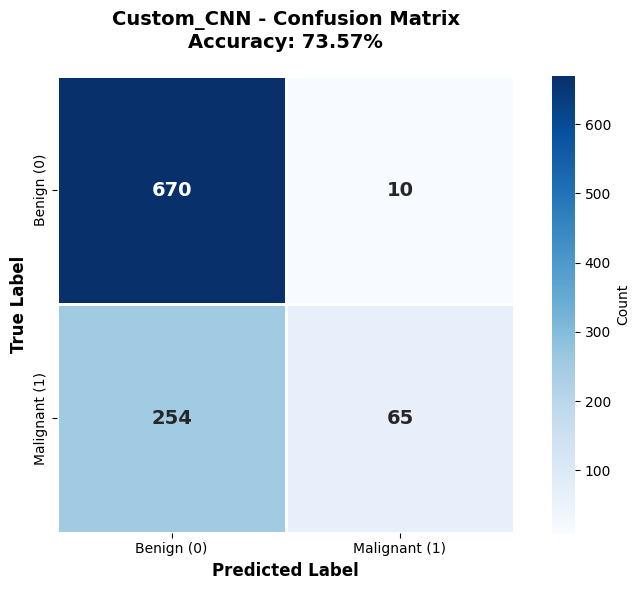

Confusion matrix saved: /content/drive/MyDrive/DermAI_Comparative_Algorithms/results/cm_Custom_CNN.png
 Saved: Custom_CNN.keras
  Checkpoint saved: Custom_CNN
  Memory cleared

MODEL 2/8: ANN
Total Parameters: 77,238,273

________________________________________________________________________________
Training: ANN
________________________________________________________________________________
Total Parameters: 77,238,273
Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 91s 609ms/step - accuracy: 0.6305 - loss: 1.6230 - precision: 0.4341 - recall: 0.4921 - val_accuracy: 0.7227 - val_loss: 1.9439 - val_precision: 0.9565 - val_recall: 0.1379 - learning_rate: 1.0000e-04
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 71s 569ms/step - accuracy: 0.7427 - loss: 1.3653 - precision: 0.5928 - recall: 0.5423 - val_accuracy: 0.7808 - val_loss: 1.2208 - val_precision: 0.7427 - val_recall: 0.4796 - learning_rate: 1.0000e-04
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 71s 563ms/step - accuracy: 0.7315 - loss: 1.3051 - 

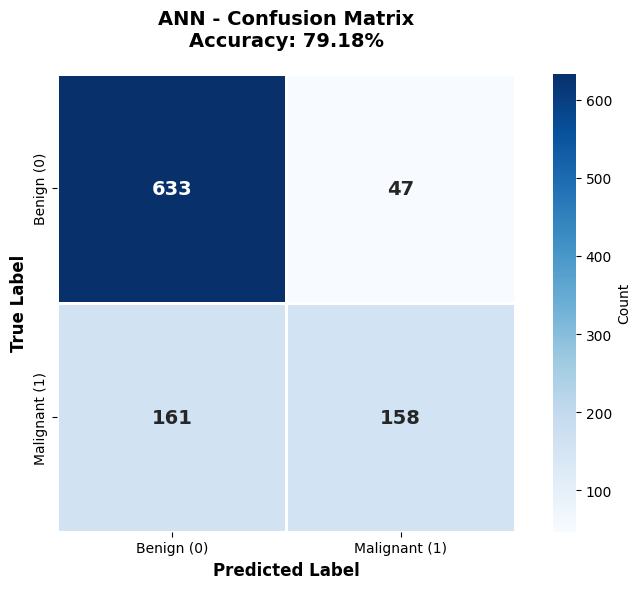

Confusion matrix saved: /content/drive/MyDrive/DermAI_Comparative_Algorithms/results/cm_ANN.png
 Saved: ANN.keras
  Checkpoint saved: ANN
  Memory cleared

MODEL 3/8: ResNet50
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Total Parameters: 24,771,457

________________________________________________________________________________
Training: ResNet50
________________________________________________________________________________
Total Parameters: 24,771,457
Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 109s 698ms/step - accuracy: 0.6908 - loss: 1.3740 - precision: 0.5030 - recall: 0.6775 - val_accuracy: 0.6967 - val_loss: 1.0778 - val_precision: 1.0000 - val_recall: 0.0502 - learning_rate: 1.0000e-04
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 71s 565ms/step - accuracy: 0.7341 - loss: 0.9705 - precision: 0.5781 - recall: 0.6864 - val_accuracy: 0.8118 - val_loss: 0.8800 - val_precision: 0.7860 - val_recall: 0.5643 - learning_rate: 1.0000e-04
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 71s 572ms/

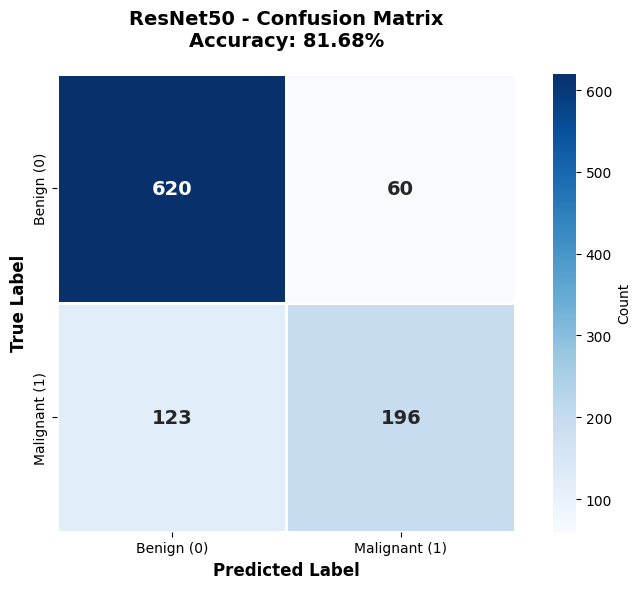

Confusion matrix saved: /content/drive/MyDrive/DermAI_Comparative_Algorithms/results/cm_ResNet50.png
 Saved: ResNet50.keras
  Checkpoint saved: ResNet50
  Memory cleared

MODEL 4/8: VGG16
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Total Parameters: 15,112,001

________________________________________________________________________________
Training: VGG16
________________________________________________________________________________
Total Parameters: 15,112,001
Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 114s 758ms/step - accuracy: 0.6310 - loss: 1.2043 - precision: 0.4468 - recall: 0.6591 - val_accuracy: 0.7798 - val_loss: 1.0136 - val_precision: 0.8561 - val_recall: 0.3730 - learning_rate: 1.0000e-04
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 75s 604ms/step - accuracy: 0.7382 - loss: 0.9574 - precision: 0.5820 - recall: 0.6999 - val_accuracy: 0.8198 - val_loss: 0.8657 - val_precision: 0.7837 - val_recall: 0.6019 - learning_rate: 1.0000e-04
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 7

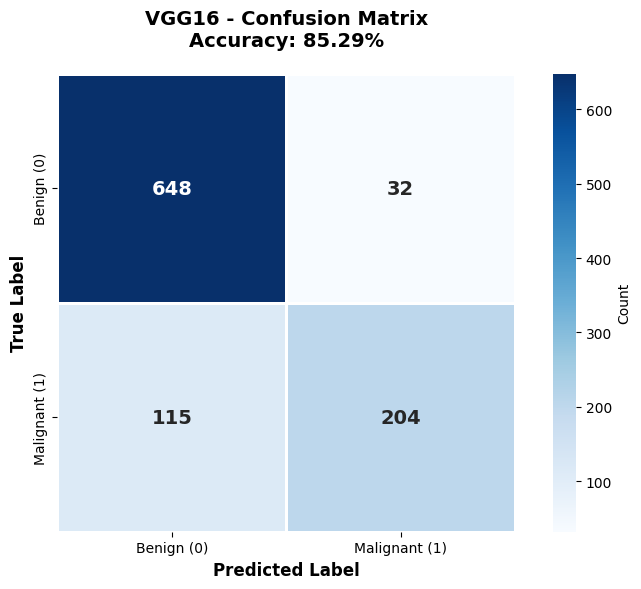

Confusion matrix saved: /content/drive/MyDrive/DermAI_Comparative_Algorithms/results/cm_VGG16.png
 Saved: VGG16.keras
  Checkpoint saved: VGG16
  Memory cleared

MODEL 5/8: EfficientNetB0
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Total Parameters: 4,840,100

________________________________________________________________________________
Training: EfficientNetB0
________________________________________________________________________________
Total Parameters: 4,840,100
Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 139s 837ms/step - accuracy: 0.5233 - loss: 1.6040 - precision: 0.3189 - recall: 0.4979 - val_accuracy: 0.6807 - val_loss: 1.2503 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 68s 543ms/step - accuracy: 0.5245 - loss: 1.4427 - precision: 0.3231 - recall: 0.4267 - val_accuracy: 0.6807 - val_loss: 1.1980 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/20
125/125

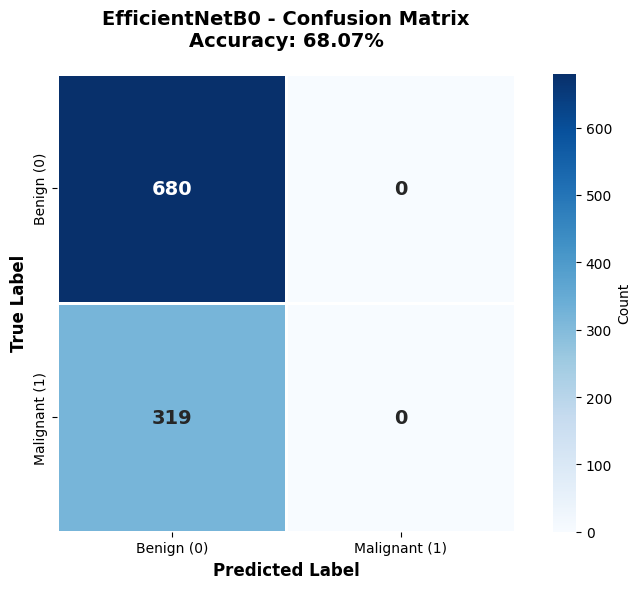

Confusion matrix saved: /content/drive/MyDrive/DermAI_Comparative_Algorithms/results/cm_EfficientNetB0.png
 Saved: EfficientNetB0.keras
  Checkpoint saved: EfficientNetB0
  Memory cleared

MODEL 6/8: InceptionV3
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Total Parameters: 22,986,529

________________________________________________________________________________
Training: InceptionV3
________________________________________________________________________________
Total Parameters: 22,986,529
Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 119s 743ms/step - accuracy: 0.5876 - loss: 1.6376 - precision: 0.4083 - recall: 0.6141 - val_accuracy: 0.7708 - val_loss: 1.3344 - val_precision: 0.6018 - val_recall: 0.8339 - learning_rate: 1.0000e-04
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 72s 572ms/step - accuracy: 0.7205 - loss: 1.4038 - precision: 0.5428 - recall: 0.7003 - val_accuracy: 0.7878 - val_loss: 1.2935 - val_precision: 0.6302 - val_recall: 0.8119 - learning_rate: 1.0000e-04
Epoch 3/20


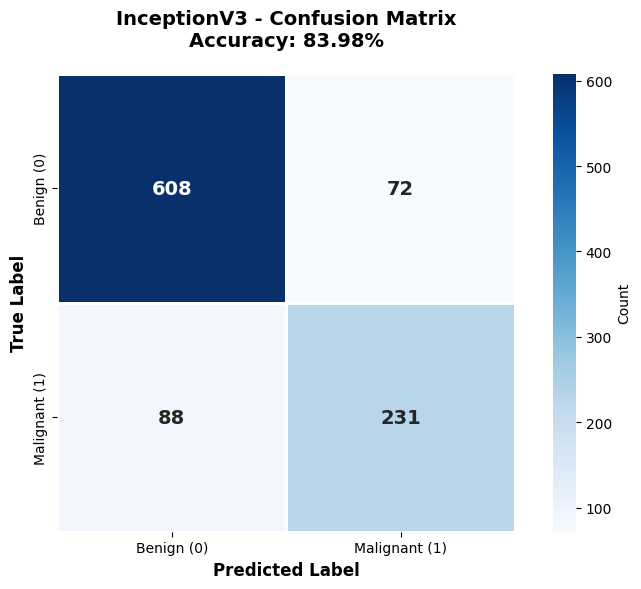

Confusion matrix saved: /content/drive/MyDrive/DermAI_Comparative_Algorithms/results/cm_InceptionV3.png
 Saved: InceptionV3.keras
  Checkpoint saved: InceptionV3
  Memory cleared

MODEL 7/8: Xception
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Total Parameters: 22,045,225

________________________________________________________________________________
Training: Xception
________________________________________________________________________________
Total Parameters: 22,045,225
Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 139s 864ms/step - accuracy: 0.6094 - loss: 1.5792 - precision: 0.4239 - recall: 0.6025 - val_accuracy: 0.7928 - val_loss: 1.3230 - val_precision: 0.6687 - val_recall: 0.6959 - learning_rate: 1.0000e-04
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 72s 576ms/step - accuracy: 0.7097 - loss: 1.4270 - precision: 0.5271 - recall: 0.6600 - val_accuracy: 0.8068 - val_loss: 1.2404 - val_precision: 0.7128 - val_recall: 0.6614 - learning_rate: 1.0000e-04
Epoch 3/20
125/125 ━━━━━━━

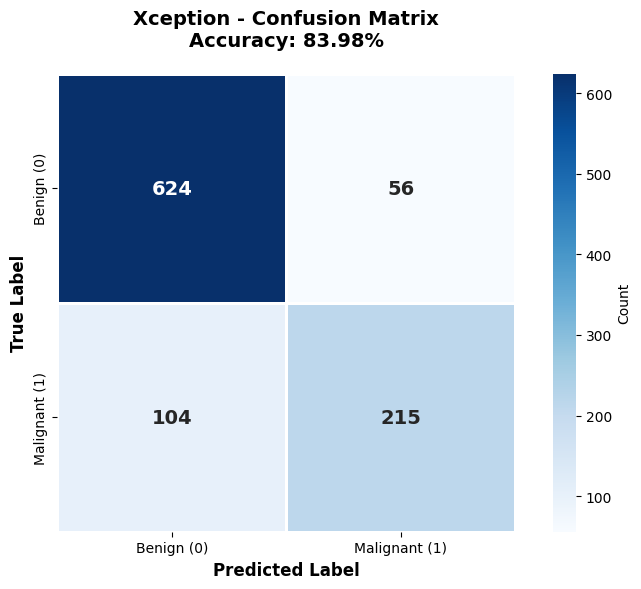

Confusion matrix saved: /content/drive/MyDrive/DermAI_Comparative_Algorithms/results/cm_Xception.png
 Saved: Xception.keras
  Checkpoint saved: Xception
  Memory cleared

MODEL 8/8: DenseNet121
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Total Parameters: 7,696,961

________________________________________________________________________________
Training: DenseNet121
________________________________________________________________________________
Total Parameters: 7,696,961
Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 151s 898ms/step - accuracy: 0.6084 - loss: 1.4538 - precision: 0.4287 - recall: 0.5813 - val_accuracy: 0.7778 - val_loss: 1.1033 - val_precision: 0.6034 - val_recall: 0.8871 - learning_rate: 1.0000e-04
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 73s 583ms/step - accuracy: 0.7378 - loss: 1.1221 - precision: 0.5814 - recall: 0.6854 - val_accuracy: 0.8068 - val_loss: 0.9380 - val_precision: 0.6514 - val_recall: 0.8495 - learning_rate: 1.0000e-04
Epoch 3/20
125/125 ━━━━━━━━━━━━

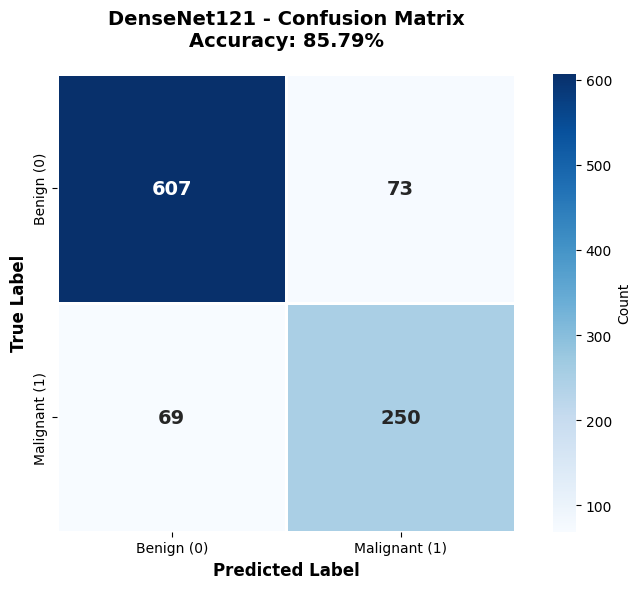

Confusion matrix saved: /content/drive/MyDrive/DermAI_Comparative_Algorithms/results/cm_DenseNet121.png
 Saved: DenseNet121.keras
  Checkpoint saved: DenseNet121
  Memory cleared

 Deep Learning Training Complete: 8/8 models


In [ ]:
print("\n" + "="*80)
print("Starting Model Training - DermAI Comparative Analysis")
print("="*80)

# Dictionary to store results
results = {}

# Models dictionary
models_dict = {
    'Custom_CNN': build_custom_cnn,
    'ANN': build_ann,
    'ResNet50': build_resnet50,
    'VGG16': build_vgg16,
    'EfficientNetB0': build_efficientnet,
    'InceptionV3': build_inceptionv3,
    'Xception': build_xception,
    'DenseNet121': build_densenet
}

# Train each model
for i, (name, builder_fn) in enumerate(models_dict.items(), 1):
    print(f"\n{'='*80}")
    print(f"MODEL {i}/{len(models_dict)}: {name}")
    print(f"{'='*80}")

    try:
        # Build model
        model = builder_fn()
        print(f"Total Parameters: {model.count_params():,}")

        # Train
        trained_model, history, train_time = train_model(
            model, name, train_generator, val_generator
        )

        if trained_model:
            # Evaluate
            metrics = evaluate_model(trained_model, name, val_generator)

            if metrics:
                # Store results
                results[name] = {
                    'model': trained_model,
                    'history': history,
                    'time': train_time,
                    'metrics': metrics
                }

                # Save model
                model_path = os.path.join(MODELS_DIR, f'{name}.keras')
                trained_model.save(model_path)
                print(f" Saved: {name}.keras")

                # Save checkpoint
                save_checkpoint(results, name)

        # Clear memory
        clear_memory()

    except Exception as e:
        print(f" ERROR training {name}: {e}")
        import traceback
        traceback.print_exc()
        continue

print("\n" + "="*80)
print(f" Deep Learning Training Complete: {len(results)}/{len(models_dict)} models")
print("="*80)

In [ ]:
# TRAIN KNN
try:
    knn_result = train_knn(split_data, max_samples=1500)
    results['KNN'] = knn_result
    save_checkpoint(results, 'KNN')
    print(" KNN training complete")
except Exception as e:
    print(f" KNN training failed: {e}")
    import traceback
    traceback.print_exc()


________________________________________________________________________________
Training: KNN
________________________________________________________________________________
KNN data: 1500 train, 999 val
Training Time: 0.01s
Accuracy: 81.38%
  Saved: cm_KNN.png
  Checkpoint saved: KNN
 KNN training complete


In [ ]:
print("\n" + "="*80)
print(f" ALL TRAINING COMPLETE: {len(results)}/9 models")
print("="*80)


 ALL TRAINING COMPLETE: 9/9 models




---



#### Section 6: Comparative Visualizations from results



---



In [ ]:
print("\n" + "="*80)
print("Generating Final Comparison Table")
print("="*80)
comp_data = []
for name, data in results.items():
    comp_data.append({
        'Model': name,
        'Accuracy (%)': data['metrics']['accuracy'] * 100,
        'Precision (%)': data['metrics']['precision'] * 100,
        'Recall (%)': data['metrics']['recall'] * 100,
        'F1-Score (%)': data['metrics']['f1_score'] * 100,
        'Training Time (s)': data['time']
    })

df_comp = pd.DataFrame(comp_data).sort_values('Accuracy (%)', ascending=False)

print("\n" + "="*80)
print("FINAL RESULTS:")
print("="*80)
print(df_comp.to_string(index=False))
print("="*80)

# Save
df_comp.to_csv(os.path.join(results_dir, 'comparison.csv'), index=False)

with open(os.path.join(results_dir, 'final_results.pkl'), 'wb') as f:
    pickle.dump(results, f)

print(f"\n All results saved to: {results_dir}")


Generating Final Comparison Table

FINAL RESULTS:
         Model  Accuracy (%)  Precision (%)  Recall (%)  F1-Score (%)  Training Time (s)
   DenseNet121     85.785786      77.399381   78.369906     77.881620        1520.127792
         VGG16     85.285285      86.440678   63.949843     73.513514        1544.349384
   InceptionV3     83.983984      76.237624   72.413793     74.276527        1465.687799
      Xception     83.983984      79.335793   67.398119     72.881356        1519.431576
      ResNet50     81.681682      76.562500   61.442006     68.173913        1312.508679
           KNN     81.381381      81.516588   53.918495     64.905660           0.014847
           ANN     79.179179      77.073171   49.529781     60.305344        1416.268994
    Custom_CNN     73.573574      86.666667   20.376176     32.994924         940.082887
EfficientNetB0     68.068068       0.000000    0.000000      0.000000        1454.528299

 All results saved to: /content/drive/MyDrive/DermAI_Compa



---



Saved: training_curves.png


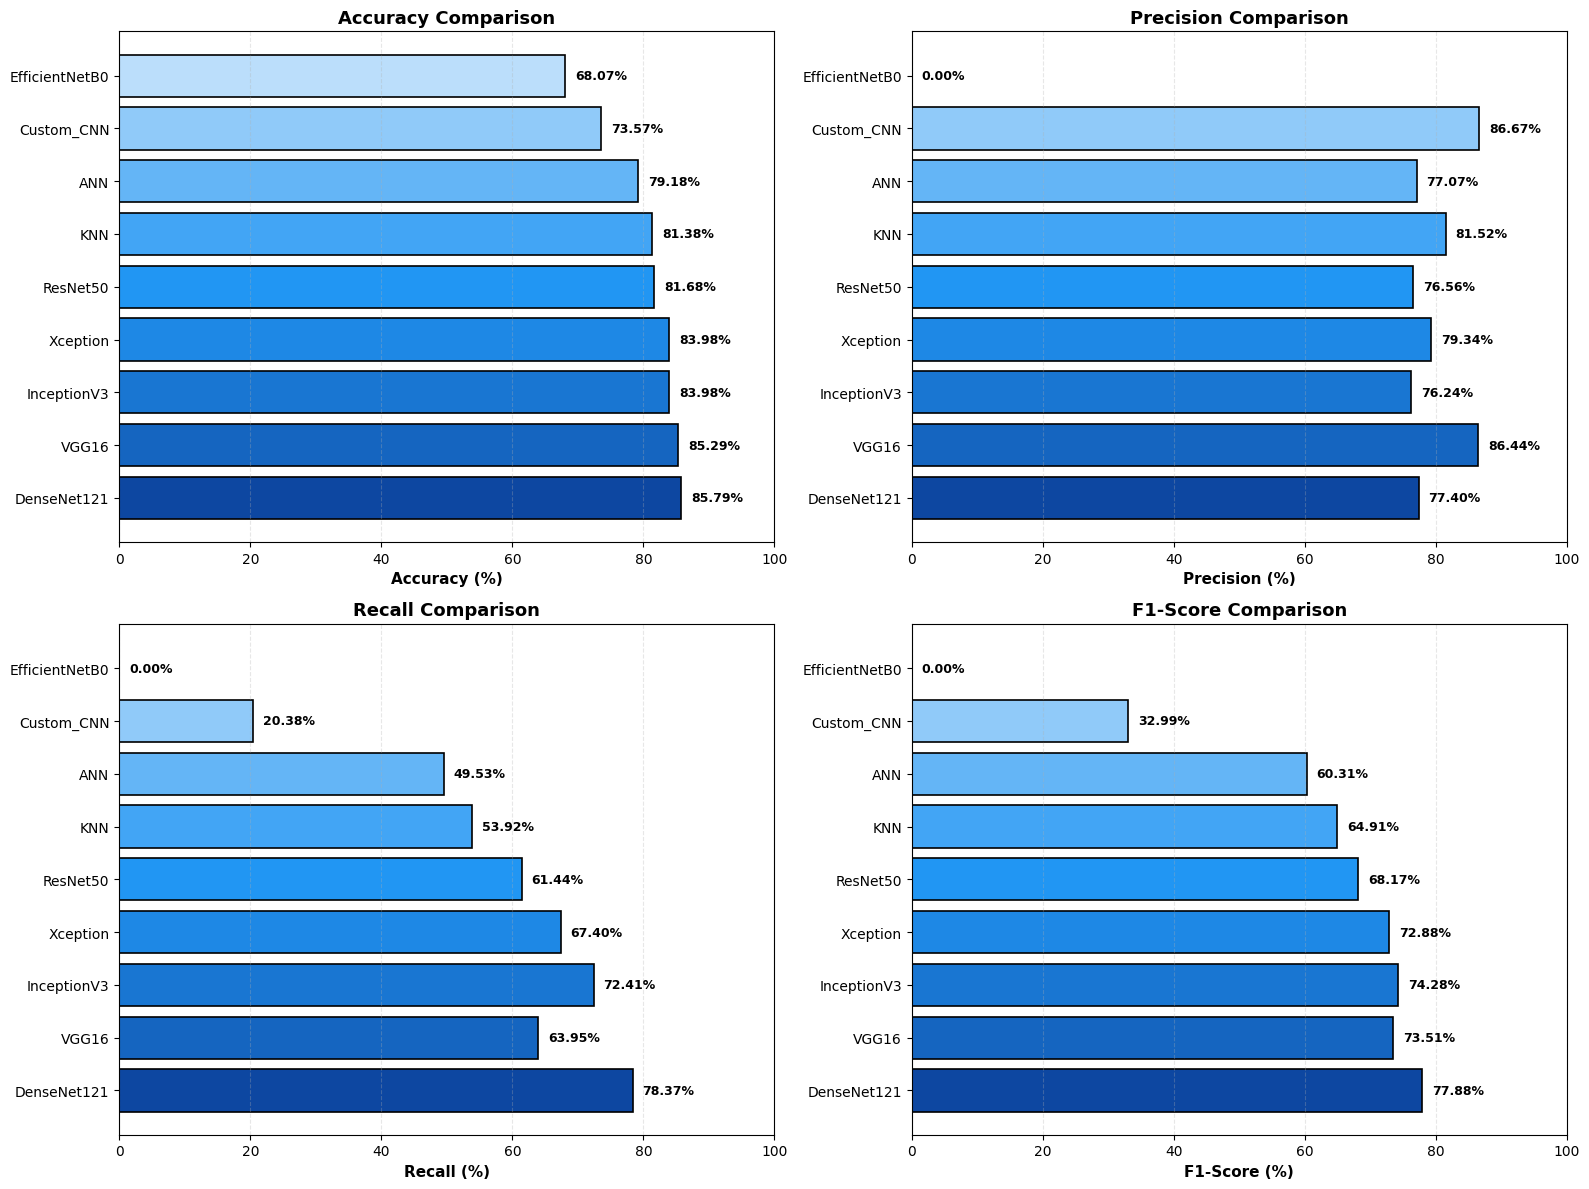

In [ ]:
# Visualization 1: Metrics Comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
models = df_comp['Model'].tolist()
colors = ['#0D47A1', '#1565C0', '#1976D2', '#1E88E5', '#2196F3', '#42A5F5', '#64B5F6', '#90CAF9', '#BBDEFB', '#E3F2FD']

axes[0,0].barh(models, df_comp['Accuracy (%)'], color=colors, edgecolor='black', linewidth=1.2)
axes[0,0].set_xlabel('Accuracy (%)', fontweight='bold', fontsize=11)
axes[0,0].set_title('Accuracy Comparison', fontweight='bold', fontsize=13)
axes[0,0].set_xlim([0,100])
axes[0,0].grid(axis='x', alpha=0.3, linestyle='--')
for i, v in enumerate(df_comp['Accuracy (%)']):
    axes[0,0].text(v+1.5, i, f'{v:.2f}%', va='center', fontweight='bold', fontsize=9)

axes[0,1].barh(models, df_comp['Precision (%)'], color=colors, edgecolor='black', linewidth=1.2)
axes[0,1].set_xlabel('Precision (%)', fontweight='bold', fontsize=11)
axes[0,1].set_title('Precision Comparison', fontweight='bold', fontsize=13)
axes[0,1].set_xlim([0,100])
axes[0,1].grid(axis='x', alpha=0.3, linestyle='--')
for i, v in enumerate(df_comp['Precision (%)']):
    axes[0,1].text(v+1.5, i, f'{v:.2f}%', va='center', fontweight='bold', fontsize=9)

axes[1,0].barh(models, df_comp['Recall (%)'], color=colors, edgecolor='black', linewidth=1.2)
axes[1,0].set_xlabel('Recall (%)', fontweight='bold', fontsize=11)
axes[1,0].set_title('Recall Comparison', fontweight='bold', fontsize=13)
axes[1,0].set_xlim([0,100])
axes[1,0].grid(axis='x', alpha=0.3, linestyle='--')
for i, v in enumerate(df_comp['Recall (%)']):
    axes[1,0].text(v+1.5, i, f'{v:.2f}%', va='center', fontweight='bold', fontsize=9)

axes[1,1].barh(models, df_comp['F1-Score (%)'], color=colors, edgecolor='black', linewidth=1.2)
axes[1,1].set_xlabel('F1-Score (%)', fontweight='bold', fontsize=11)
axes[1,1].set_title('F1-Score Comparison', fontweight='bold', fontsize=13)
axes[1,1].set_xlim([0,100])
axes[1,1].grid(axis='x', alpha=0.3, linestyle='--')
for i, v in enumerate(df_comp['F1-Score (%)']):
    axes[1,1].text(v+1.5, i, f'{v:.2f}%', va='center', fontweight='bold', fontsize=9)

plt.tight_layout()

save_path = '/content/drive/MyDrive/DermAI_Comparative_Algorithms/results/training_curves.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Saved: training_curves.png")
plt.show()

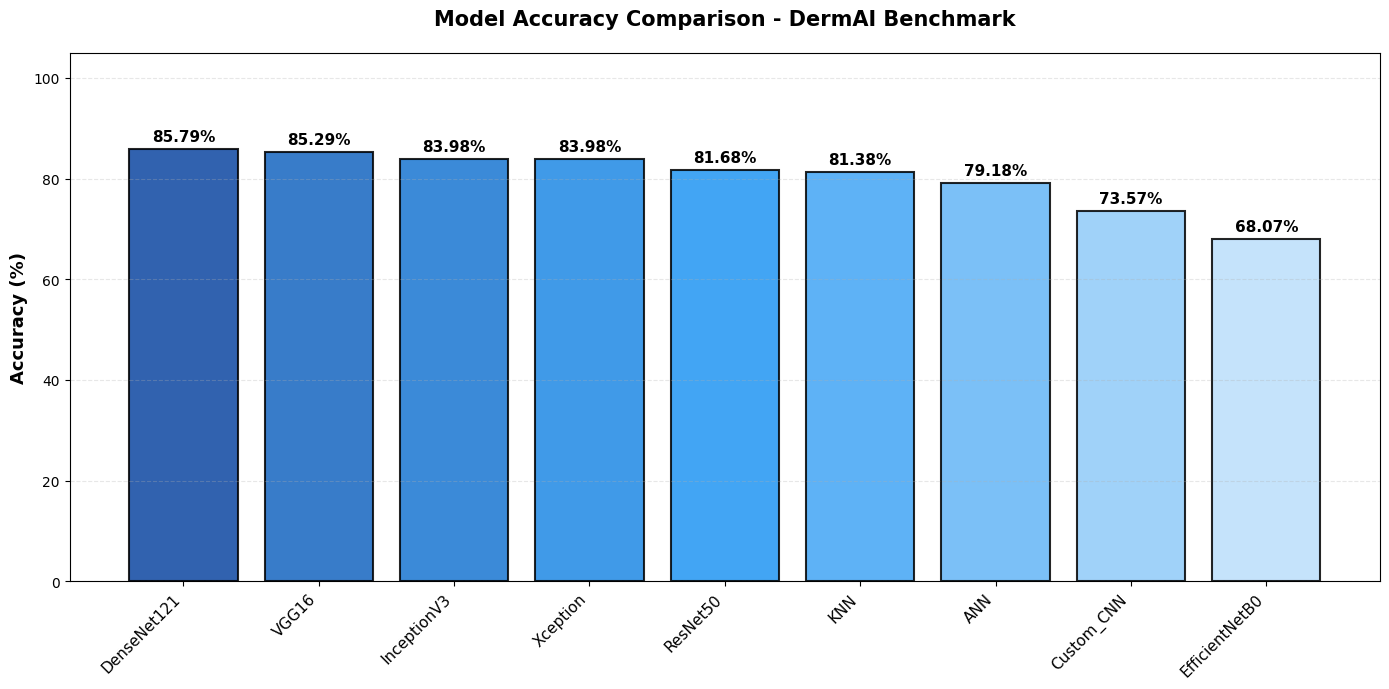

Saved: accuracy_bar_chart.png


In [ ]:
# Visualization 2: Grouped Bar Chart (Accuracy vs Model)
plt.figure(figsize=(14, 7))

x = np.arange(len(models))
bars = plt.bar(x, df_comp['Accuracy (%)'], color=colors,
               edgecolor='black', linewidth=1.5, alpha=0.85)

# Add accuracy labels on top of bars
for i, (bar, val) in enumerate(zip(bars, df_comp['Accuracy (%)'])):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{val:.2f}%',
             ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.xticks(x, models, rotation=45, ha='right', fontsize=11)
plt.ylabel('Accuracy (%)', fontweight='bold', fontsize=13)
plt.title('Model Accuracy Comparison - DermAI Benchmark',
          fontweight='bold', fontsize=15, pad=20)
plt.ylim([0, 105])
plt.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/DermAI_Comparative_Algorithms/results/accuracy_bar_chart.png',
            dpi=300, bbox_inches='tight')
plt.show()
print("Saved: accuracy_bar_chart.png")

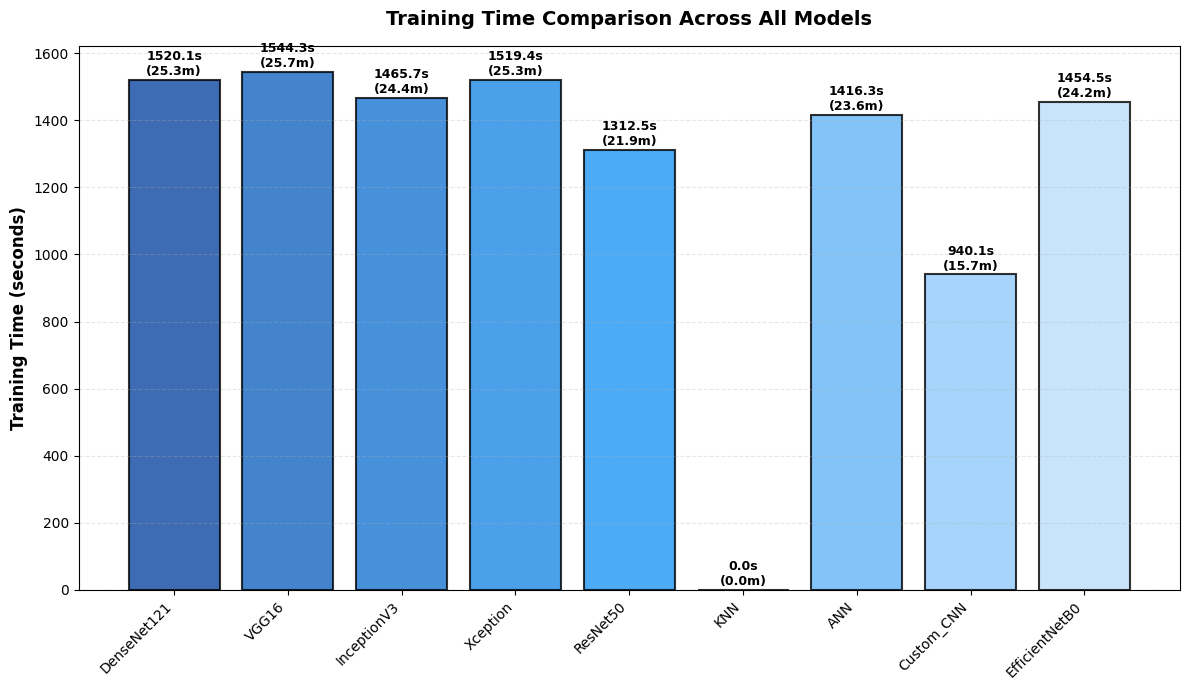

Saved: training_time.png


In [ ]:
# Visualization 3: Training Time Comparison
plt.figure(figsize=(12,7))
bars = plt.bar(range(len(models)), df_comp['Training Time (s)'],
               color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)
plt.xticks(range(len(models)), models, rotation=45, ha='right', fontsize=10)
plt.ylabel('Training Time (seconds)', fontweight='bold', fontsize=12)
plt.title('Training Time Comparison Across All Models', fontweight='bold', fontsize=14, pad=15)
plt.grid(axis='y', alpha=0.3, linestyle='--')

for i, (bar, val) in enumerate(zip(bars, df_comp['Training Time (s)'])):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{val:.1f}s\n({val/60:.1f}m)',
             ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/DermAI_Comparative_Algorithms/results/training_time.png',
            dpi=300, bbox_inches='tight')
plt.show()
print("Saved: training_time.png")

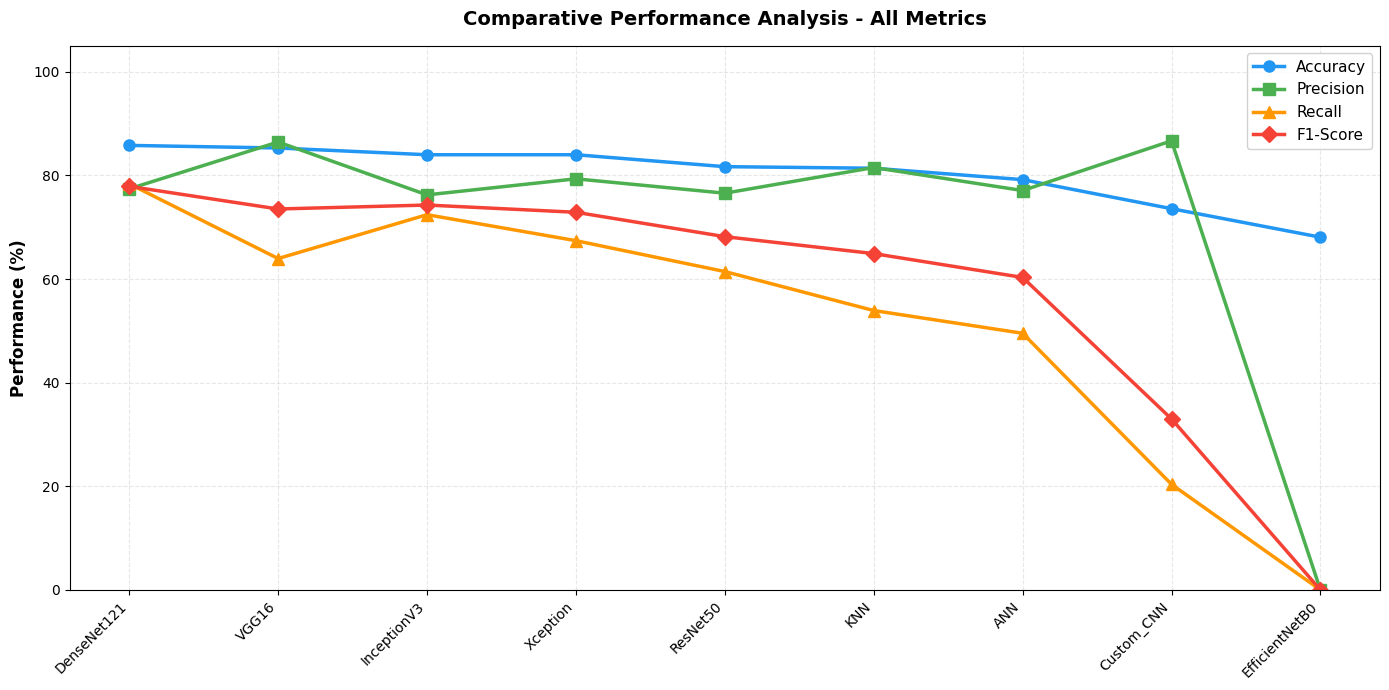

Saved: performance_chart.png


In [ ]:
# Visualization 4: Performance Line Chart
plt.figure(figsize=(14, 7))

x = np.arange(len(models))
width = 0.2

plt.plot(x, df_comp['Accuracy (%)'], marker='o', linewidth=2.5,
         label='Accuracy', color='#2196F3', markersize=8)
plt.plot(x, df_comp['Precision (%)'], marker='s', linewidth=2.5,
         label='Precision', color='#4CAF50', markersize=8)
plt.plot(x, df_comp['Recall (%)'], marker='^', linewidth=2.5,
         label='Recall', color='#FF9800', markersize=8)
plt.plot(x, df_comp['F1-Score (%)'], marker='D', linewidth=2.5,
         label='F1-Score', color='#F44336', markersize=8)

plt.xticks(x, models, rotation=45, ha='right', fontsize=10)
plt.ylabel('Performance (%)', fontweight='bold', fontsize=12)
plt.title('Comparative Performance Analysis - All Metrics',
          fontweight='bold', fontsize=14, pad=15)
plt.legend(loc='best', fontsize=11, framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle='--')
plt.ylim([0, 105])

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/DermAI_Comparative_Algorithms/results/performance_chart.png',
            dpi=300, bbox_inches='tight')
plt.show()
print("Saved: performance_chart.png")

______________________________________________________________

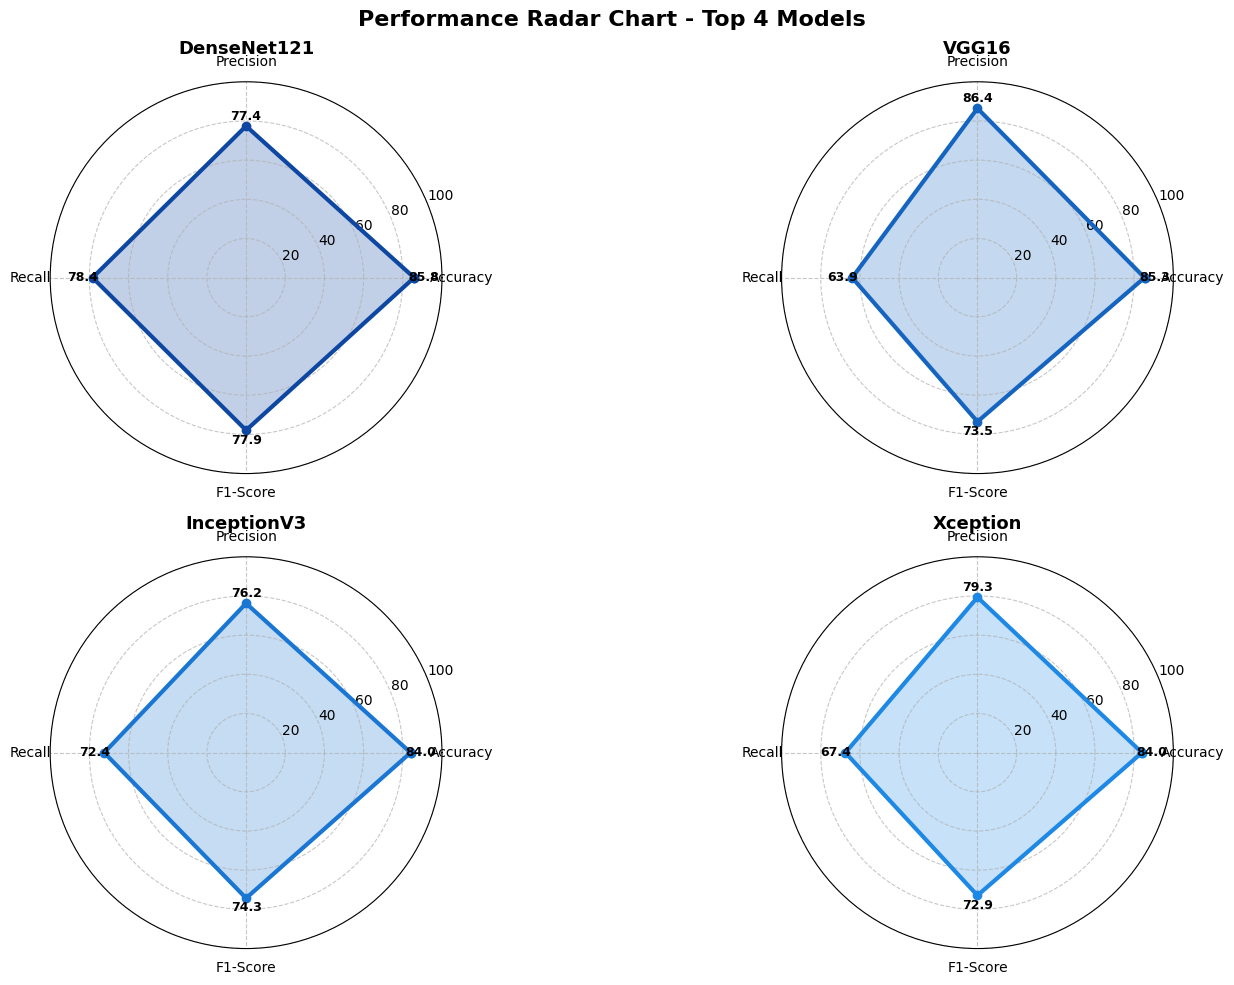

Saved: radar_comparison.png


In [ ]:
# Visualization 5: Radar Chart Comparison (Best 4 Models)
from math import pi

# Select top 4 models by accuracy
top4 = df_comp.head(4)
categories = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

fig = plt.figure(figsize=(16, 10))

for idx, (_, row) in enumerate(top4.iterrows()):
    ax = fig.add_subplot(2, 2, idx+1, projection='polar')

    values = [
        row['Accuracy (%)'],
        row['Precision (%)'],
        row['Recall (%)'],
        row['F1-Score (%)']
    ]
    values += values[:1]

    angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
    angles += angles[:1]

    ax.plot(angles, values, 'o-', linewidth=3, color=colors[idx], label=row['Model'])
    ax.fill(angles, values, alpha=0.25, color=colors[idx])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=10)
    ax.set_ylim(0, 100)
    ax.set_title(f"{row['Model']}", fontsize=13, fontweight='bold', pad=20)
    ax.grid(True, linestyle='--', alpha=0.7)

    # Add value labels
    for angle, value in zip(angles[:-1], values[:-1]):
        ax.text(angle, value + 5, f'{value:.1f}',
                ha='center', va='center', fontsize=9, fontweight='bold')

plt.suptitle('Performance Radar Chart - Top 4 Models',
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/DermAI_Comparative_Algorithms/results/radar_comparison.png',
            dpi=300, bbox_inches='tight')
plt.show()
print("Saved: radar_comparison.png")

In [ ]:
print("\n" + "_"*80)
print(f"Total execution time: {sum(df_comp['Training Time (s)']):.2f}s")
print(f"                      ({sum(df_comp['Training Time (s)'])/60:.2f} minutes)")
print("_"*80)


________________________________________________________________________________
Total execution time: 11173.00s
                      (186.22 minutes)
________________________________________________________________________________


  

---





---



#### Section 7: Final Summary

In [ ]:
print("\nSaving trained models...")
models_dir = '/content/drive/MyDrive/DermAI_Comparative_Algorithms/models'
os.makedirs(models_dir, exist_ok=True)

# Save only models that exist in memory and are Keras objects
for name, data in results.items():
    model_obj = data.get('model', None)
    if model_obj and hasattr(model_obj, 'save'):
        model_path = os.path.join(models_dir, f"{name}.keras")
        model_obj.save(model_path)
        print(f" Saved: {name}.keras")
    else:
        print(f"Skipped {name} (not a Keras model or not found).")

print("\nAll models saved successfully!")
print("="*80)

# Save the metrics comparison figure
plt.savefig('/content/drive/MyDrive/DermAI_Comparative_Algorithms/results/metrics_comparison.png',
            dpi=300, bbox_inches='tight')
plt.show()
print("Saved: metrics_comparison.png")

In [ ]:
print("\n" + "_"*80)
print("Final Analysis and CNN Justification for DermAI")
print("_"*80)

best_acc = df_comp.loc[df_comp['Accuracy (%)'].idxmax()]
best_f1 = df_comp.loc[df_comp['F1-Score (%)'].idxmax()]
fastest = df_comp.loc[df_comp['Training Time (s)'].idxmin()]

print(f"\n Key Findings:")
print(f"{'_'*80}")
print(f" Best Accuracy:    {best_acc['Model']} ({best_acc['Accuracy (%)']:.2f}%)")
print(f" Best F1-Score:    {best_f1['Model']} ({best_f1['F1-Score (%)']:.2f}%)")
print(f" Fastest Training: {fastest['Model']} ({fastest['Training Time (s)']:.2f}s)")

print(f"\n Performance Summary:")
print(f"{'_'*80}")
for _, row in df_comp.iterrows():
    print(f"{row['Model']:20s} | Acc: {row['Accuracy (%)']:6.2f}% | "
          f"Prec: {row['Precision (%)']:6.2f}% | "
          f"Rec: {row['Recall (%)']:6.2f}% | "
          f"F1: {row['F1-Score (%)']:6.2f}% | "
          f"Time: {row['Training Time (s)']:7.2f}s")

print("\n" + "_"*80)

_____________________________________________________

In [ ]:
print("\n" + "_"*85)
print(" All Results Saved To:")
print("_"*85)

base_path = "/content/drive/MyDrive/DermAI_Comparative_Algorithms/results/"

print(f" {base_path}")
print("   ├── comparison.csv                 → Performance table")
print("   ├── summary_report.txt             → Final text summary")
print("   ├── cm_Custom_CNN.png              → Confusion matrix")
print("   ├── cm_ResNet50.png                → Confusion matrix")
print("   ├── cm_VGG16.png                   → Confusion matrix")
print("   ├── cm_EfficientNetB0.png          → Confusion matrix")
print("   ├── cm_ANN.png                     → Confusion matrix")
print("   ├── cm_KNN.png                     → Confusion matrix")
print("   ├── metrics_comparison.png         → Bar charts (4 metrics)")
print("   ├── training_time.png              → Training time comparison")
print("   ├── performance_chart.png          → Line performance chart")
print("   ├── training_curves.png            → Accuracy/Loss curves")
print("   ├── accuracy_bar_chart.png         → Accuracy bars")
print("   └── radar_comparison.png           → Radar visualization")
print("_"*85)

__________________________________________________________________